In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import Counter
from collections import defaultdict

In [2]:
from sklearn.model_selection import train_test_split, cross_val_score 

from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [3]:
df = pd.read_csv('df_track_final.csv')

In [4]:
df.drop(columns=['Unnamed: 0'], inplace=True)

In [5]:
df_new = df.copy()

In [6]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

# fit and transform the 'album_type' column
df_new['album_type'] = label_encoder.fit_transform(df_new['album_type'])
df_new['album_type'] 

0        0
1        2
2        1
3        2
4        2
        ..
97444    2
97445    2
97446    0
97447    2
97448    0
Name: album_type, Length: 97449, dtype: int32

In [7]:
no_use = ['id', 'name', 'disc_number', 'duration_ms', 'track_number', 
          'artists', 'album_name', 'album_release_date', 'album_release_date_precision',
          'album_total_tracks', 'month_year', 'year1']
df_new = df_new.drop(no_use, axis=1)

In [8]:
X = df_new.drop(columns=['genre'])
y = df_new['genre']

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.25, stratify = y, random_state = 7)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((73086, 25), (24363, 25), (73086,), (24363,))

# Classification

In [10]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold

In [11]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

[14, 15, 16, 17, 18]


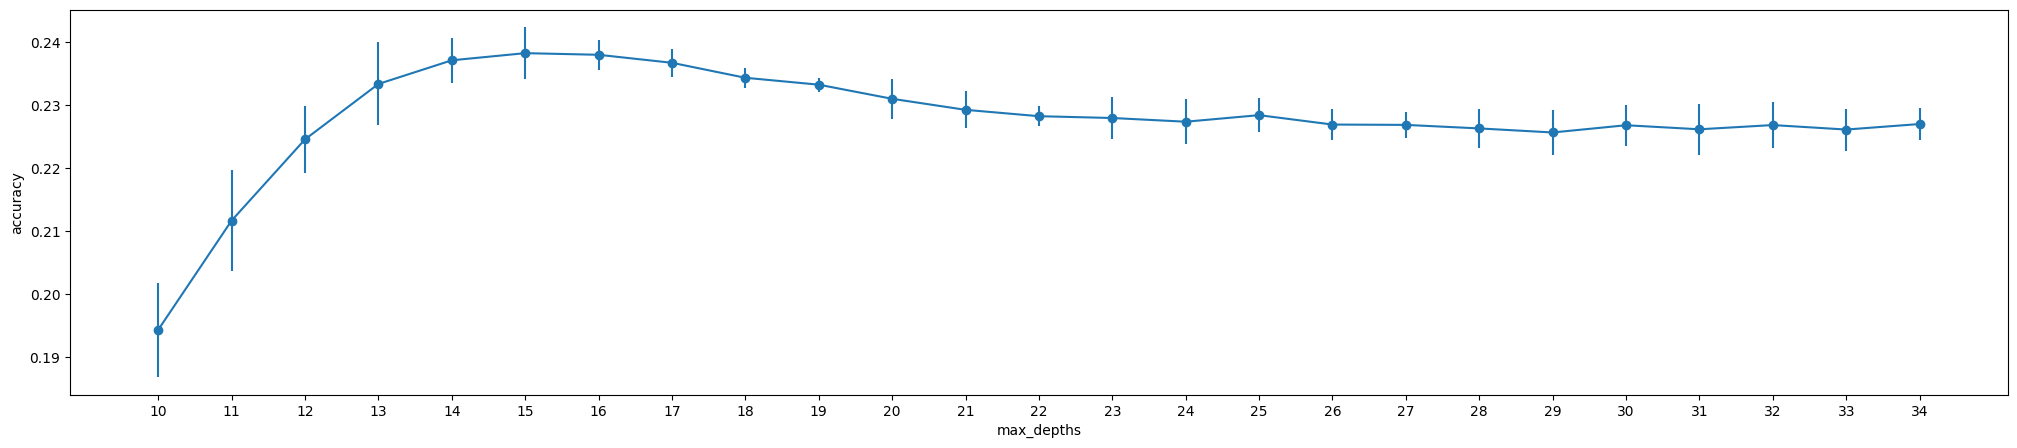

In [12]:
def depth_param_graph(interval, train_X, train_y, cv):
  max_depths = interval
  avg_scores = list()
  std_scores = list()
  scores = list()

  for max_depth in max_depths:
      dt = DecisionTreeClassifier(max_depth=max_depth)
      cross_val_scores = cross_val_score(dt, train_X, train_y, cv=cv)
      avg_scores.append(np.mean(cross_val_scores))
      std_scores.append(np.std(cross_val_scores))
      avg_score = np.mean(cross_val_scores)
      std_score = np.std(cross_val_scores)
      scores.append((max_depth, avg_score, std_score))

  scores.sort(key=lambda x: x[1], reverse=True)
  range_depth = sorted([t[0] for t in scores[:5]])
  print(range_depth)

  plt.figure(figsize=(25,5))
  plt.errorbar(range(len(max_depths)), y=avg_scores, yerr=std_scores, marker='o')
  plt.xticks(range(len(max_depths)), max_depths)
  plt.xlabel("max_depths")
  plt.ylabel("accuracy")
  plt.show()

  return range_depth

range_depth = depth_param_graph(interval=range(10, 35, 1), train_X=X_train_scaled, train_y=y_train, cv=5)

[16, 18, 20, 22, 24]


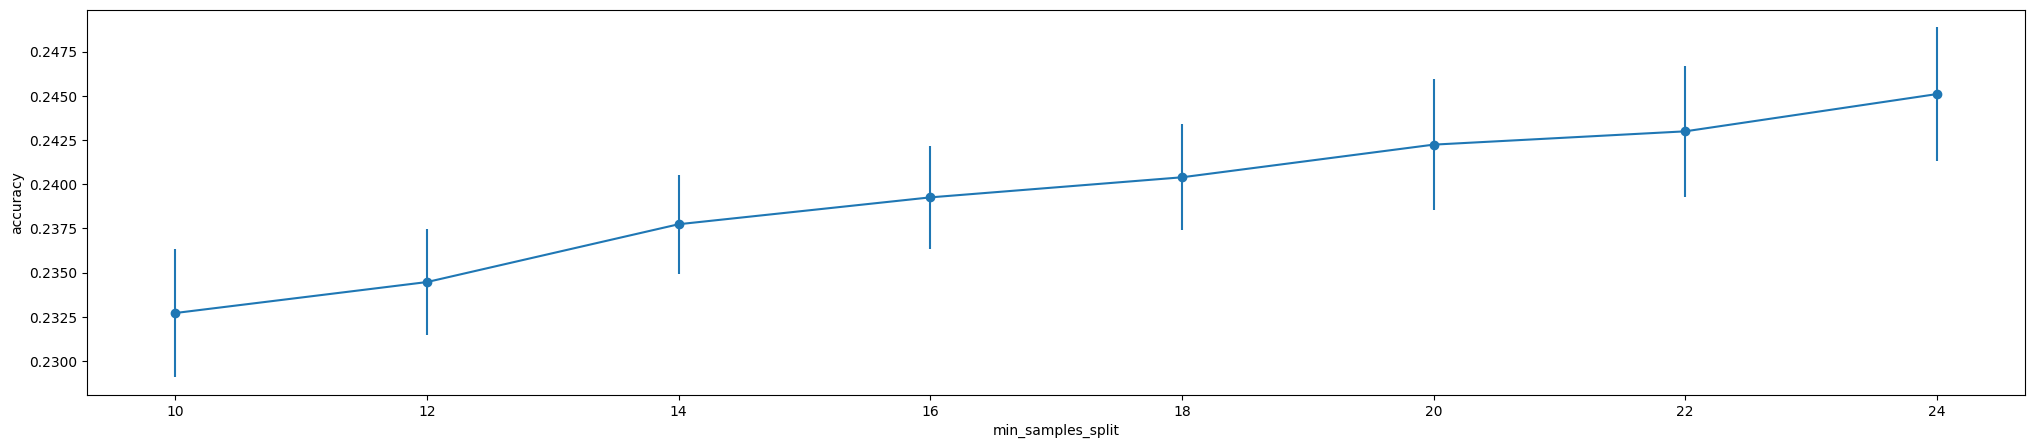

In [13]:
def split_param_graph(interval, train_X, train_y, cv):
  min_samples_splits = interval
  avg_scores = list()
  std_scores = list()
  scores = list()

  for min_samples_split in min_samples_splits:
     dt = DecisionTreeClassifier(min_samples_split=min_samples_split)
     cross_val_scores = cross_val_score(dt, train_X, train_y, cv=cv)
     avg_scores.append(np.mean(cross_val_scores))
     std_scores.append(np.std(cross_val_scores))
     avg_score = np.mean(cross_val_scores)
     std_score = np.std(cross_val_scores)
     scores.append((min_samples_split, avg_score, std_score))

  scores.sort(key=lambda x: x[1], reverse=True)
  range_split = sorted([t[0] for t in scores[:5]])
  print(range_split)

  plt.figure(figsize=(25,5))
  plt.errorbar(range(len(min_samples_splits)), y=avg_scores, yerr=std_scores, marker='o')
  plt.xticks(range(len(min_samples_splits)), min_samples_splits)
  plt.xlabel("min_samples_split")
  plt.ylabel("accuracy")
  plt.show()

  return range_split

range_split = split_param_graph(interval=range(10, 25, 2), train_X=X_train_scaled, train_y=y_train, cv=5)

[12, 13, 14, 19, 21]


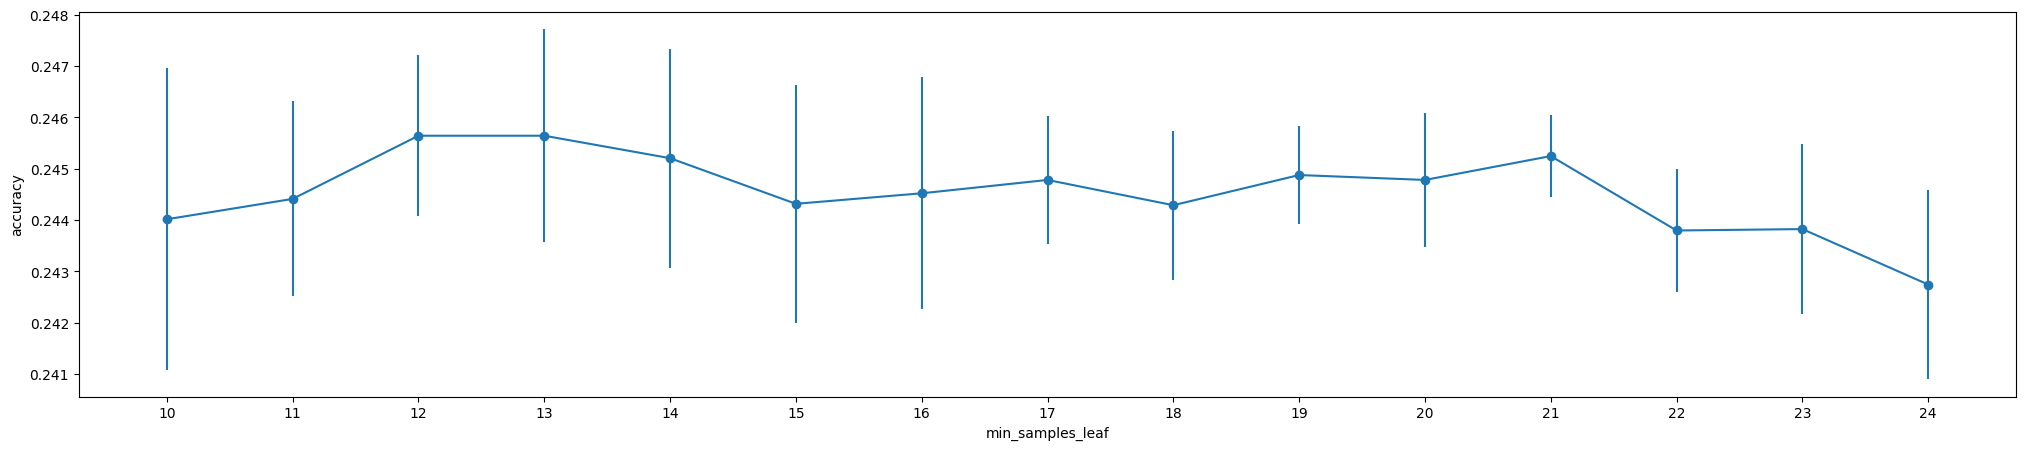

In [14]:
def leaf_param_graph(interval, train_X, train_y, cv):
  min_samples_leafs = interval
  avg_scores = list()
  std_scores = list()
  scores = list()

  for min_samples_leaf in min_samples_leafs:
     dt = DecisionTreeClassifier(min_samples_leaf=min_samples_leaf)
     cross_val_scores = cross_val_score(dt, train_X, train_y, cv=cv)
     avg_scores.append(np.mean(cross_val_scores))
     std_scores.append(np.std(cross_val_scores))
     avg_score = np.mean(cross_val_scores)
     std_score = np.std(cross_val_scores)
     scores.append((min_samples_leaf, avg_score, std_score))

  scores.sort(key=lambda x: x[1], reverse=True)
  range_leaf = sorted([t[0] for t in scores[:5]])
  print(range_leaf)

  plt.figure(figsize=(25,5))
  plt.errorbar(range(len(min_samples_leafs)), y=avg_scores, yerr=std_scores, marker='o')
  plt.xticks(range(len(min_samples_leafs)), min_samples_leafs)
  plt.xlabel("min_samples_leaf")
  plt.ylabel("accuracy")
  plt.show()

  return range_leaf

range_leaf = leaf_param_graph(interval=range(10, 25, 1), train_X=X_train_scaled, train_y=y_train, cv=5)

In [15]:
%%time
# 35min

# TODO: implement tqdm

param_list = { # based on graphs above
    'max_depth': range_depth,
    'min_samples_split': range_split,
    'min_samples_leaf': range_leaf,
    'criterion': ['gini', 'entropy'],
    'splitter':['best']
}

random_search = RandomizedSearchCV(
    DecisionTreeClassifier(),
    param_distributions=param_list,
    cv=RepeatedStratifiedKFold(random_state=0),
    refit=True, scoring='accuracy', n_jobs=-1, verbose=10
)


CPU times: total: 0 ns
Wall time: 1.51 ms


In [16]:
random_search.fit(X_train_scaled, y_train)
dt = random_search.best_estimator_

Fitting 50 folds for each of 10 candidates, totalling 500 fits


In [17]:
print(dt)

DecisionTreeClassifier(criterion='entropy', max_depth=17, min_samples_leaf=14,
                       min_samples_split=20)


In [18]:
random_search.best_params_

{'splitter': 'best',
 'min_samples_split': 20,
 'min_samples_leaf': 14,
 'max_depth': 17,
 'criterion': 'entropy'}

In [19]:
y_train_pred_dt = dt.predict(X_train_scaled)
y_test_pred_dt = dt.predict(X_test_scaled)

In [20]:
print('Train Accuracy %s' % accuracy_score(y_train, y_train_pred_dt))
print('Train F1-score %s' % f1_score(y_train, y_train_pred_dt, average=None))
print()
print('Test Accuracy %s' % accuracy_score(y_test, y_test_pred_dt))
print('Test F1-score %s' % f1_score(y_test, y_test_pred_dt, average=None))

Train Accuracy 0.4052759762471609
Train F1-score [0.29310345 0.35925256 0.30712074 0.29042486 0.38817734 0.37068443
 0.55403557 0.40933573 0.30090791 0.22737472 0.41081081 0.33974359
 0.40323668 0.60012323 0.51125    0.33311037 0.59490085 0.35703919
 0.12269939 0.45009536 0.55785627 0.29012346 0.39565217 0.30113636
 0.55643045 0.28793774 0.51564186 0.54571843 0.25142857 0.21383648
 0.20056497 0.42409034 0.22025723 0.34247591 0.25588235 0.46207296
 0.26572327 0.30195382 0.31333333 0.32958199 0.42049934 0.23417173
 0.81595092 0.4043956  0.48019802 0.41995532 0.47067343 0.39160839
 0.37335399 0.5444521  0.43162393 0.42219215 0.72663387 0.35608726
 0.44622793 0.33791431 0.23908046 0.27755749 0.39742673 0.8361809
 0.44113475 0.54328358 0.27329193 0.25601241 0.48101266 0.55744392
 0.60348432 0.34535104 0.28858579 0.26887132 0.41369863 0.2649789
 0.4620887  0.50409836 0.2901474  0.58502024 0.46258503 0.39888164
 0.56824513 0.47667087 0.43183493 0.45702865 0.39882698 0.33447099
 0.4752     0.2

In [21]:
print(classification_report(y_test, y_test_pred_dt))

                   precision    recall  f1-score   support

         acoustic       0.16      0.18      0.17       239
         afrobeat       0.15      0.19      0.17       234
         alt-rock       0.11      0.13      0.12       238
      alternative       0.13      0.16      0.14       243
          ambient       0.23      0.28      0.25       158
            anime       0.23      0.34      0.28       229
      black-metal       0.39      0.51      0.44       207
        bluegrass       0.22      0.29      0.25       226
            blues       0.15      0.18      0.17       239
           brazil       0.07      0.09      0.08       207
        breakbeat       0.26      0.27      0.27       229
          british       0.28      0.18      0.22       121
         cantopop       0.22      0.28      0.24       212
    chicago-house       0.38      0.54      0.45       226
         children       0.37      0.48      0.42       229
            chill       0.23      0.25      0.24       

## KNN

In [22]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

In [23]:
scaler = MinMaxScaler()
X_train_scaled_knn = scaler.fit_transform(X_train)
X_test_scaled_knn = scaler.transform(X_test)

In [24]:
# define a range of k
param_grid = {'n_neighbors': [10, 11,12,13,14,15,16,17,18,19,20, 21,22,23,24,25],'weights': ['uniform','distance'],
              'metric':['euclidean','manhattan']}

In [25]:
# create KNN classifier
knn_classifier = KNeighborsClassifier()
grid_search = GridSearchCV(knn_classifier, param_grid, cv=5)

In [26]:
a = grid_search.fit(X_train_scaled_knn, y_train)

C:\Users\minhd\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\minhd\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\minhd\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\minhd\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 764, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
                             ^^^^^^^^^^^^^^^
  F

In [27]:
a.cv_results_.keys()
print(a.best_score_,a.best_params_)

0.24446542298009827 {'metric': 'manhattan', 'n_neighbors': 24, 'weights': 'distance'}


In [28]:
y_train_pred_knn = a.predict(X_train_scaled_knn)
y_test_pred_knn = a.predict(X_test_scaled_knn)

In [29]:
print('Train Accuracy %s' % accuracy_score(y_train, y_train_pred_knn))
print('Train F1-score %s' % f1_score(y_train, y_train_pred_knn, average=None))
print()
print('Test Accuracy %s' % accuracy_score(y_test, y_test_pred_knn))
print('Test F1-score %s' % f1_score(y_test, y_test_pred_knn, average=None))

Train Accuracy 0.8483430479161536
Train F1-score [0.93429698 0.98941426 0.57501081 0.54320988 0.88432836 0.85268414
 0.97798742 0.99191771 0.72738025 0.74203623 0.98494624 1.
 1.         1.         0.99638467 0.86554096 0.88221154 0.99494585
 0.98723404 0.94371091 0.99594046 1.         0.99888018 1.
 1.         0.99891892 1.         1.         1.         1.
 0.65746333 0.68806306 0.88105118 0.81306715 0.70485096 0.95050847
 0.9570284  0.75407512 0.90703851 0.82987552 0.87619048 0.92686357
 0.9961627  0.9165488  0.87832168 0.96229508 0.9052774  0.70157068
 0.8562963  0.95489891 0.98243045 0.79069767 1.         0.61446809
 0.99843505 0.74385511 0.57006152 0.56042972 0.89949385 1.
 0.98253275 0.97442799 0.71071199 0.68868704 0.70175439 0.91678035
 0.98389458 0.5472103  0.55016181 0.99082569 0.99726402 0.48808389
 0.91333836 0.87978509 0.80390684 0.9566075  0.94528302 0.85220729
 0.96938013 0.86114101 0.80202312 0.82454624 0.94736842 0.85106383
 0.8556231  0.65027322 0.57392996 0.69550173 

In [30]:
print(classification_report(y_test, y_test_pred_knn))

                   precision    recall  f1-score   support

         acoustic       0.18      0.17      0.18       239
         afrobeat       0.27      0.20      0.23       234
         alt-rock       0.03      0.05      0.03       238
      alternative       0.11      0.13      0.12       243
          ambient       0.23      0.20      0.22       158
            anime       0.17      0.16      0.16       229
      black-metal       0.33      0.36      0.34       207
        bluegrass       0.31      0.28      0.30       226
            blues       0.18      0.17      0.17       239
           brazil       0.01      0.01      0.01       207
        breakbeat       0.26      0.18      0.21       229
          british       0.29      0.08      0.13       121
         cantopop       0.18      0.25      0.21       212
    chicago-house       0.35      0.50      0.41       226
         children       0.58      0.42      0.49       229
            chill       0.14      0.14      0.14       

# Feature Selection

## Variance Threshold

In [31]:
from sklearn.feature_selection import VarianceThreshold

In [32]:
sel = VarianceThreshold(threshold=(.8 * (1 - .8)))
X_train_sel = sel.fit_transform(X_train)

X_train_sel.shape

(73086, 12)

[17, 18, 19, 21, 22]


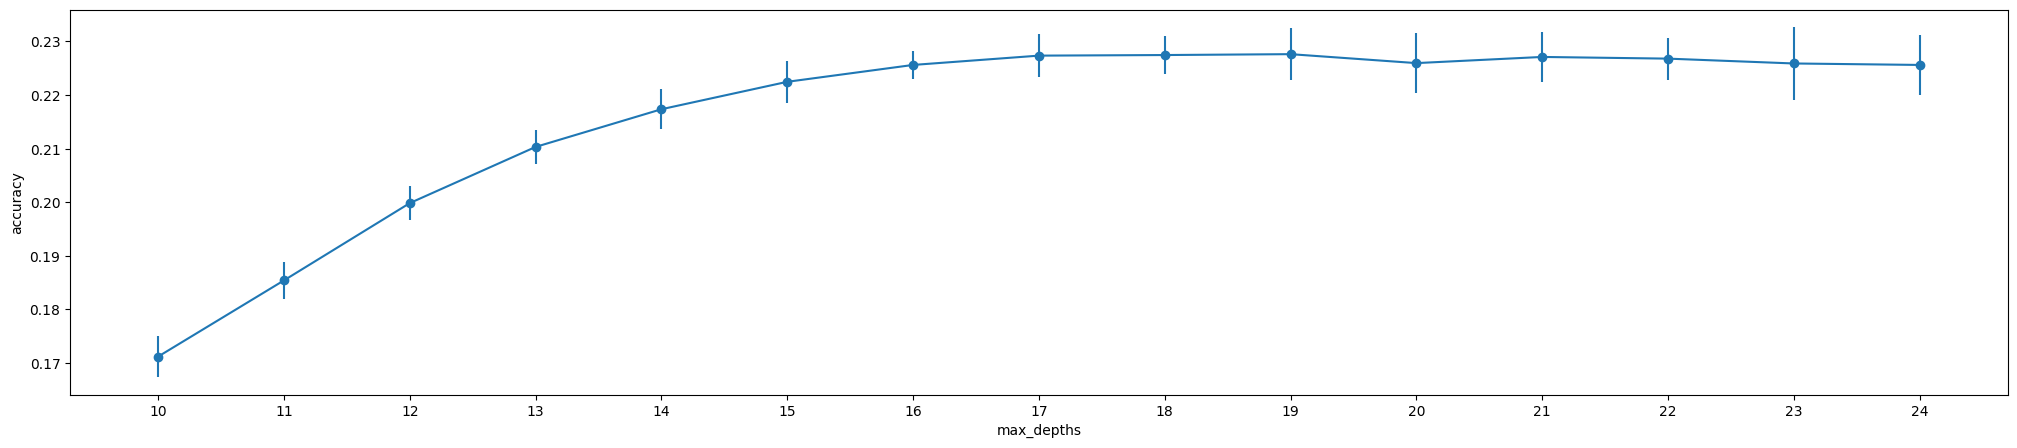

[20, 21, 22, 23, 24]


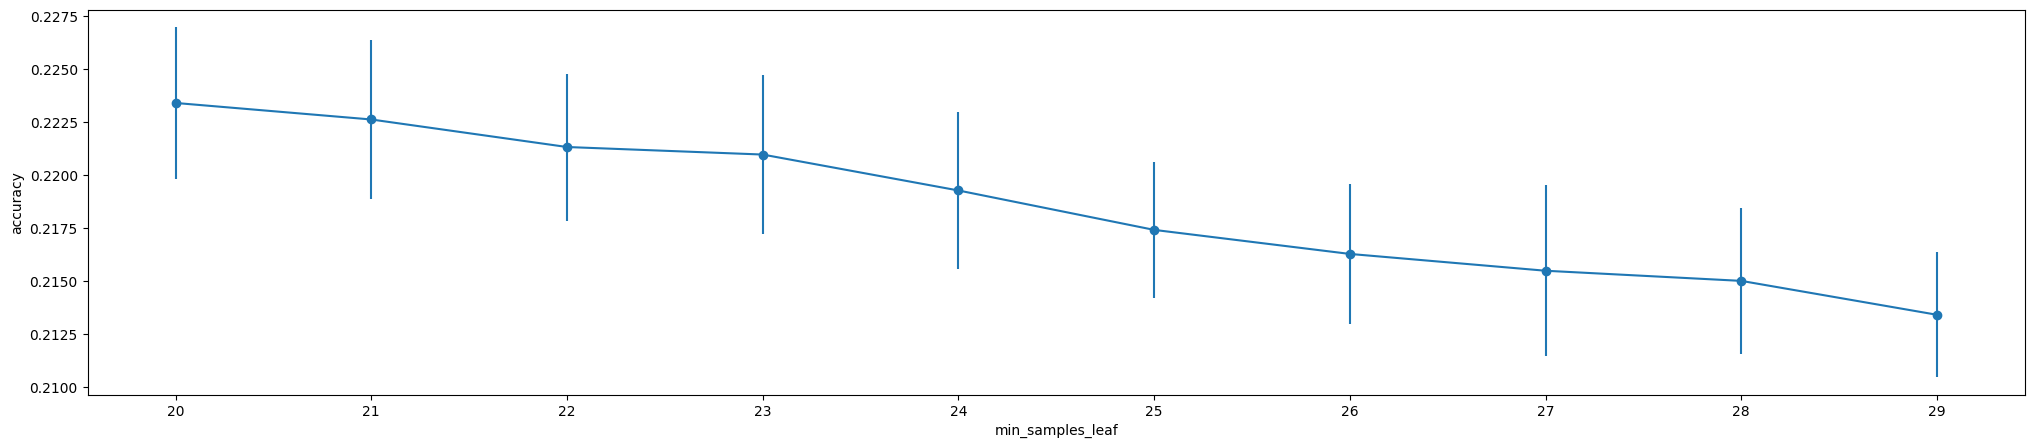

[17, 19, 21, 23, 25]


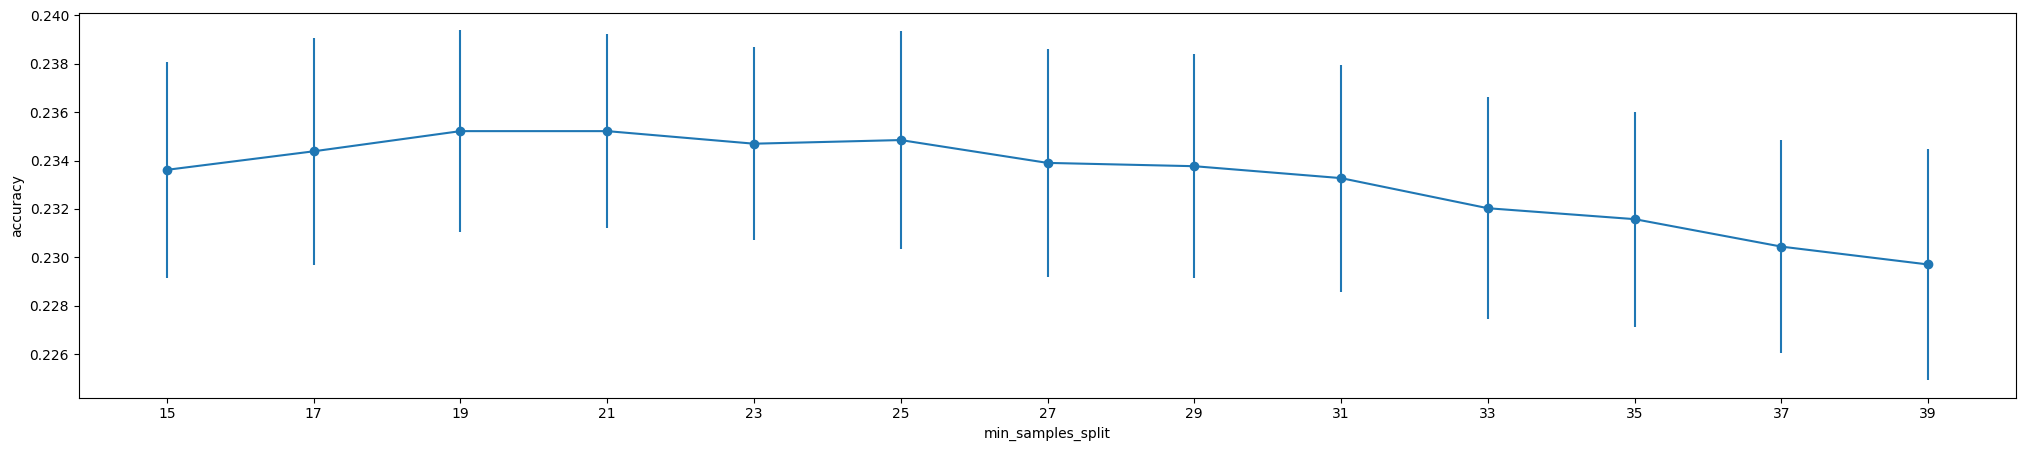

In [33]:
range_depth = depth_param_graph(interval=range(10, 25, 1), train_X=X_train_sel, train_y=y_train, cv=5)
range_leaf = leaf_param_graph(interval=range(20, 30, 1), train_X=X_train_sel, train_y=y_train, cv=5)
range_split = split_param_graph(interval=range(15, 40, 2), train_X=X_train_sel, train_y=y_train, cv=5)

In [34]:
param_list = { # based on graphs above
    'max_depth': range_depth,
    'min_samples_split': range_split,
    'min_samples_leaf': range_leaf,
    'criterion': ['gini'],
    'splitter':['best']
}

random_search = RandomizedSearchCV(
    DecisionTreeClassifier(),
    param_distributions=param_list,
    cv=RepeatedStratifiedKFold(random_state=0),
    refit=True, scoring='accuracy', n_jobs=-1, verbose=10
)

In [35]:
random_search.fit(X_train_sel, y_train)
ct = random_search.best_estimator_

Fitting 50 folds for each of 10 candidates, totalling 500 fits


In [36]:
random_search.best_params_

{'splitter': 'best',
 'min_samples_split': 21,
 'min_samples_leaf': 20,
 'max_depth': 21,
 'criterion': 'gini'}

In [37]:
X_test_sel = sel.transform(X_test)

clf = DecisionTreeClassifier(criterion='gini',splitter='best',max_depth=20, min_samples_leaf=20, 
                             min_samples_split=23, random_state=42)
clf.fit(X_train_sel, y_train)

y_pred = clf.predict(X_test_sel)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred, digits=3))

Accuracy 0.23145753807002423
F1-score [0.11472275 0.14949495 0.08333333 0.16691505 0.17261905 0.14814815
 0.22440945 0.16053512 0.15238095 0.10267857 0.21653543 0.16216216
 0.19189765 0.41048035 0.39506173 0.13162706 0.52816901 0.15011038
 0.         0.30280374 0.47583643 0.11267606 0.10612245 0.12903226
 0.41450777 0.11333333 0.44897959 0.42982456 0.11111111 0.
 0.08144796 0.24105461 0.06372549 0.19195046 0.09569378 0.26641651
 0.135      0.13636364 0.17894737 0.15946844 0.1995842  0.10655738
 0.50530786 0.18595041 0.26388889 0.12       0.22417582 0.19354839
 0.12406948 0.45982143 0.28174603 0.28899083 0.57731959 0.25228519
 0.23665893 0.16580311 0.08237986 0.13053613 0.24200913 0.69002695
 0.15897436 0.35205993 0.10199557 0.1106383  0.425      0.37547893
 0.41763341 0.15584416 0.08551069 0.1108742  0.25680934 0.12236287
 0.21442495 0.33201581 0.16803279 0.28478964 0.1589404  0.1607717
 0.45472062 0.27659574 0.34013605 0.36197441 0.25508318 0.24295011
 0.37231504 0.08121827 0.11909651

C:\Users\minhd\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\minhd\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                   precision    recall  f1-score   support

         acoustic      0.106     0.126     0.115       239
         afrobeat      0.142     0.158     0.149       234
         alt-rock      0.087     0.080     0.083       238
      alternative      0.131     0.230     0.167       243
          ambient      0.163     0.184     0.173       158
            anime      0.140     0.157     0.148       229
      black-metal      0.189     0.275     0.224       207
        bluegrass      0.129     0.212     0.161       226
            blues      0.140     0.167     0.152       239
           brazil      0.095     0.111     0.103       207
        breakbeat      0.197     0.240     0.217       229
          british      0.178     0.149     0.162       121
         cantopop      0.175     0.212     0.192       212
    chicago-house      0.405     0.416     0.410       226
         children      0.331     0.489     0.395       229
            chill      0.117     0.151     0.132       

C:\Users\minhd\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Univariate Feature Selection

In [38]:
from sklearn.feature_selection import SelectKBest

In [39]:
ufl = SelectKBest(k=15)
X_train_ufl = ufl.fit_transform(X_train, y_train)

X_train_ufl.shape

(73086, 15)

In [40]:
X_test_ufl = ufl.transform(X_test)

clf = DecisionTreeClassifier(criterion='gini',splitter='best',max_depth=20, min_samples_leaf=20, 
                             min_samples_split=23, random_state=42)
clf.fit(X_train_ufl, y_train)

y_pred = clf.predict(X_test_ufl)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred, digits=3))

Accuracy 0.24783483150679309
F1-score [0.16216216 0.16771488 0.11131059 0.11563169 0.26923077 0.18526316
 0.45517241 0.26760563 0.12652068 0.08312958 0.1691974  0.06629834
 0.25051335 0.43673469 0.41911765 0.15135135 0.51779935 0.16702355
 0.         0.3006993  0.3943662  0.11173184 0.17791411 0.10408922
 0.4372093  0.09846154 0.43949045 0.35348837 0.17721519 0.
 0.04040404 0.20715631 0.05449591 0.1319797  0.12456747 0.24705882
 0.15121951 0.17169374 0.19534884 0.12234043 0.23770492 0.09368635
 0.67532468 0.17726397 0.30078125 0.29023747 0.264      0.19138756
 0.171875   0.23831776 0.39912281 0.2815735  0.60816327 0.20998279
 0.32717678 0.15571776 0.11594203 0.15277778 0.26086957 0.73563218
 0.21445221 0.40310078 0.09734513 0.09430255 0.38518519 0.36015326
 0.53578732 0.17716535 0.09223301 0.14604462 0.27610619 0.14611872
 0.29805616 0.34018692 0.17094017 0.39793282 0.37014925 0.19076923
 0.39759036 0.2962963  0.26987952 0.35853132 0.20731707 0.23152709
 0.288      0.08192771 0.1009174

C:\Users\minhd\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\minhd\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                   precision    recall  f1-score   support

         acoustic      0.176     0.151     0.162       239
         afrobeat      0.165     0.171     0.168       234
         alt-rock      0.097     0.130     0.111       238
      alternative      0.121     0.111     0.116       243
          ambient      0.238     0.310     0.269       158
            anime      0.179     0.192     0.185       229
      black-metal      0.434     0.478     0.455       207
        bluegrass      0.222     0.336     0.268       226
            blues      0.151     0.109     0.127       239
           brazil      0.084     0.082     0.083       207
        breakbeat      0.168     0.170     0.169       229
          british      0.100     0.050     0.066       121
         cantopop      0.222     0.288     0.251       212
    chicago-house      0.405     0.473     0.437       226
         children      0.362     0.498     0.419       229
            chill      0.132     0.176     0.151       

C:\Users\minhd\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Recursive Feature Elimination (RFE)

In [41]:
from sklearn.feature_selection import RFE

In [42]:
sel = RFE(DecisionTreeClassifier(), n_features_to_select=15)
X_train_sel = sel.fit_transform(X_train, y_train)
X_train_sel.shape

(73086, 15)

In [43]:
X_test_sel = sel.transform(X_test)

clf = DecisionTreeClassifier(criterion='gini',splitter='best',max_depth=20, min_samples_leaf=20, 
                             min_samples_split=23, random_state=42)
clf.fit(X_train_sel, y_train)

y_pred = clf.predict(X_test_sel)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred, digits=3))

Accuracy 0.2511595452120018
F1-score [0.11235955 0.14007782 0.10131332 0.13934426 0.26136364 0.17063492
 0.37687366 0.2787194  0.13983051 0.12462908 0.22522523 0.04444444
 0.2504817  0.42677824 0.38043478 0.17931034 0.55892256 0.1607565
 0.04       0.29513344 0.37671233 0.16304348 0.18122977 0.15767635
 0.44552058 0.11805556 0.42724458 0.38522427 0.15277778 0.07207207
 0.09836066 0.22303473 0.04477612 0.16326531 0.10021786 0.268
 0.18013857 0.20524017 0.21002387 0.15131579 0.24596774 0.10550459
 0.66964286 0.15230461 0.29588015 0.28776978 0.27680312 0.17857143
 0.19444444 0.36842105 0.36363636 0.27974948 0.58153242 0.19262295
 0.29468599 0.16624685 0.08743169 0.10526316 0.1826484  0.70523416
 0.28571429 0.38535645 0.09381663 0.11235955 0.37231504 0.35181644
 0.52192067 0.16247582 0.10294118 0.13422819 0.2754717  0.12933025
 0.29716981 0.37969925 0.1509434  0.41573034 0.31176471 0.22099448
 0.39238095 0.27924528 0.29247312 0.3518931  0.24351297 0.21585903
 0.28412256 0.08333333 0.075829

## Select Form Model

In [44]:
from sklearn.feature_selection import SelectFromModel

In [45]:
sel = SelectFromModel(DecisionTreeClassifier())
X_train_sel = sel.fit_transform(X_train, y_train)
X_train_sel.shape

(73086, 11)

In [46]:
X_test_sel = sel.transform(X_test)

clf = DecisionTreeClassifier(criterion='gini',splitter='best',max_depth=20, min_samples_leaf=20, 
                             min_samples_split=23, random_state=42)
clf.fit(X_train_sel, y_train)

y_pred = clf.predict(X_test_sel)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred, digits=3))

Accuracy 0.24684973114969422
F1-score [0.12520593 0.20774648 0.08205128 0.13888889 0.27565982 0.20606061
 0.34684685 0.29411765 0.18217822 0.09473684 0.23694779 0.08421053
 0.28517824 0.47334755 0.34423408 0.21376812 0.53846154 0.18818381
 0.03703704 0.29558541 0.37873754 0.15568862 0.19018405 0.09677419
 0.47169811 0.10181818 0.38922156 0.36939314 0.17368421 0.
 0.05504587 0.19784946 0.04662005 0.12598425 0.08200456 0.27152318
 0.15313225 0.17902813 0.21495327 0.1320132  0.26819923 0.13924051
 0.60566449 0.19067797 0.28517824 0.29268293 0.33399602 0.216
 0.20235294 0.39467849 0.37580994 0.24827586 0.57821782 0.22879684
 0.2919708  0.1038961  0.08290155 0.10606061 0.22559653 0.72159091
 0.2566586  0.3653484  0.0896861  0.1171875  0.42857143 0.29906542
 0.49079755 0.14876033 0.13983051 0.10666667 0.24416517 0.14851485
 0.3238512  0.37209302 0.07228916 0.40853659 0.37419355 0.22839506
 0.4        0.26382979 0.28968254 0.23505976 0.23706897 0.15625
 0.3025641  0.06637168 0.10045662 0.0534

# Feature Projection

### PCA

In [47]:
from sklearn.decomposition import PCA

In [48]:
pca = PCA(n_components=2)
pca.fit(X_train)
X_train_pca = pca.transform(X_train)

In [49]:
X_train_pca.shape

(73086, 2)

In [50]:
X_test_pca = pca.transform(X_test)

clf = DecisionTreeClassifier(criterion='gini',splitter='best',max_depth=20, min_samples_leaf=22, 
                             min_samples_split=18, random_state=42)
clf.fit(X_train_pca, y_train)

y_pred = clf.predict(X_test_pca)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.22107293847227352
F1-score [0.15619048 0.1038961  0.05965463 0.14854111 0.11299435 0.21544715
 0.12997904 0.1443662  0.144      0.06646526 0.24108659 0.18
 0.24901186 0.28257457 0.44444444 0.13333333 0.38211382 0.20512821
 0.10714286 0.20772947 0.47004608 0.17721519 0.1124498  0.03463203
 0.28680688 0.09836066 0.22739018 0.14965986 0.04375    0.
 0.05882353 0.22348485 0.11501597 0.27135678 0.16129032 0.24263432
 0.07384615 0.16413374 0.22477064 0.10135135 0.224      0.204
 0.36177474 0.16085791 0.37024793 0.19480519 0.24646465 0.33193277
 0.12776413 0.07655502 0.33087149 0.32206759 0.61343013 0.14893617
 0.14903846 0.18770227 0.09326425 0.13471503 0.31578947 0.55474453
 0.25376344 0.47530864 0.19686801 0.15920398 0.35204082 0.38862559
 0.42013889 0.11790393 0.10230179 0.2        0.28770302 0.09032258
 0.26185958 0.24909747 0.09169054 0.20300752 0.12121212 0.14166667
 0.24381625 0.31545741 0.30601093 0.26824458 0.1824     0.08333333
 0.40339703 0.08917197 0.08722741 0.1781170

### t-SNE

In [51]:
from sklearn.manifold import TSNE

In [52]:
tsne = TSNE(n_components=2)
X_train_tsne = tsne.fit_transform(X_train)
X_train_tsne.shape

(73086, 2)

In [53]:
#X_test_mds = mds.transform(X_test) # no transform

clf = DecisionTreeClassifier(min_samples_leaf=3, random_state=42)
clf.fit(X_train_tsne, y_train)

y_pred = clf.predict(X_train_tsne)

print('Accuracy %s' % accuracy_score(y_train, y_pred))
print('F1-score %s' % f1_score(y_train, y_pred, average=None))
print(classification_report(y_train, y_pred))

Accuracy 0.508606299428071
F1-score [0.49771879 0.51120256 0.47137405 0.51026758 0.49688581 0.50978474
 0.48742138 0.50439024 0.5025227  0.43320068 0.51540041 0.51209677
 0.54433498 0.57416808 0.68009479 0.49286092 0.56184486 0.51528879
 0.43533123 0.67808624 0.8        0.49319456 0.44897959 0.43347639
 0.56710255 0.49692713 0.54934211 0.50909091 0.44197359 0.31701632
 0.44404655 0.59727972 0.42447419 0.51033668 0.48403576 0.55241682
 0.42458899 0.4606414  0.47840532 0.5        0.50079745 0.48743017
 0.62059035 0.46997776 0.64686023 0.46746988 0.47214076 0.5577957
 0.43276662 0.40034813 0.54283548 0.5996081  0.76511955 0.51209992
 0.43676069 0.46821705 0.43969466 0.4349232  0.51808118 0.66804979
 0.53907496 0.64301231 0.49512378 0.40545145 0.6269196  0.69491525
 0.56685348 0.51576293 0.46100759 0.45753899 0.58912387 0.41955556
 0.53670473 0.51333333 0.3888335  0.44963145 0.38995215 0.49237984
 0.55491329 0.57614213 0.53475936 0.53238687 0.50163399 0.42608696
 0.62944162 0.41509434 0.36

### Random Subspace Projection

In [54]:
from sklearn import random_projection

In [55]:
rsp = random_projection.GaussianRandomProjection(n_components=2, random_state=0)
X_train_rsp = rsp.fit_transform(X_train)
X_train_rsp.shape

(73086, 2)

In [56]:
X_test_rsp = rsp.transform(X_test)

clf = DecisionTreeClassifier(min_samples_leaf=3, random_state=42)
clf.fit(X_train_rsp, y_train)

y_pred = clf.predict(X_test_rsp)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.1793293108402085
F1-score [0.10923277 0.14531044 0.06077348 0.12589928 0.11328125 0.10510949
 0.07153966 0.10526316 0.14110429 0.02333333 0.13186813 0.16233766
 0.20116054 0.16029144 0.38461538 0.1307815  0.33810888 0.15272727
 0.02040816 0.47407407 0.63087248 0.1446384  0.10471204 0.04334365
 0.12121212 0.13370474 0.23255814 0.1322314  0.07098121 0.01398601
 0.04347826 0.26229508 0.10922787 0.21455939 0.09872029 0.22789784
 0.07867495 0.18951613 0.12889813 0.19117647 0.10900474 0.12269939
 0.26048565 0.10502283 0.3449692  0.095      0.12903226 0.27848101
 0.05405405 0.05235602 0.21686747 0.35610766 0.554371   0.19952494
 0.10796915 0.14634146 0.0531401  0.13043478 0.25060241 0.25786164
 0.22751323 0.31932773 0.17924528 0.06185567 0.40105541 0.46985447
 0.2412993  0.14471243 0.08163265 0.17       0.28505747 0.10242588
 0.23188406 0.15348837 0.08746356 0.15555556 0.08480565 0.18705036
 0.29176471 0.28873239 0.34020619 0.25730994 0.15571776 0.08695652
 0.42819843 0.07940447 0.